## Installing:

```pip install --user opencv-contrib-python```

Credit to https://github.com/fooock for my start point

In [205]:
from matplotlib import pyplot as plt

import cv2

import numpy as np

%matplotlib inline

## Read image

In [206]:
image = cv2.imread("dgrim.jpg")
print('size: {} shape: {}'.format(image.size, image.shape))

size: 5784000 shape: (1205, 1600, 3)


## Get only one channel

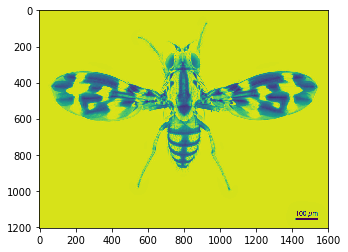

In [207]:
plt.imshow(image[:,:,2])

## Convert to gray scale

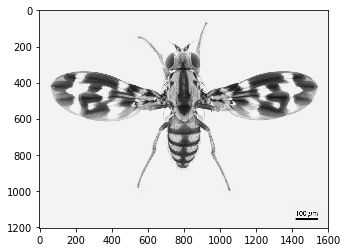

In [208]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

## Normalize between 0 and 1

In [36]:
gray_norm = cv2.normalize(gray, gray, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

## Keypoint detection

In [38]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints = sift.detect(gray, None)

## Draw keypoints

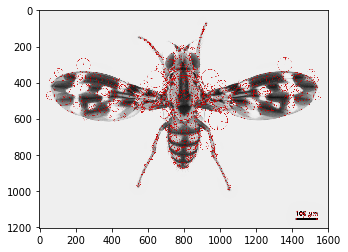

In [40]:
res = cv2.drawKeypoints(gray, keypoints, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, color=(200, 0, 0))

plt.imshow(res)

## Add noise

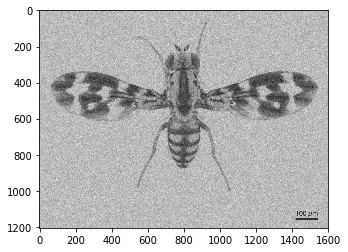

In [47]:
noisy = gray  + np.random.normal(size=gray.shape) * 25.
plt.imshow(noisy, cmap='gray')

## Smooth

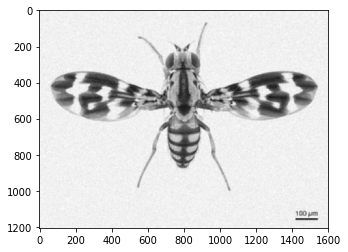

In [52]:
sigma = 3
smooth = cv2.blur(noisy, (9, 9), sigma)
plt.imshow(smooth, cmap='gray')

Im prinzip faehrt man dafuer nur einen gaussian kernel (a) ueber das bild und mach ein weighted average. Normales average kann man nicht nehmen weil es scheisse aussieht(b). Macht auch sinn: Wichtiger ist, was direkt in der naehe ist, weniger je weiter weg.

Ein Kernel sieht so aus:

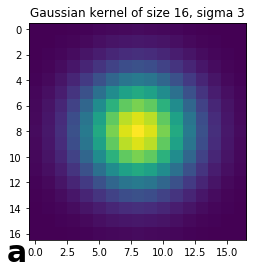

In [194]:
def create_gaussian_kernel(size=3, sigma=0.05):
    if type(size) == int:
        height, width = size, size
    else:
        height, width = size
    hrange = np.linspace(-height//2 + (1 if (width % 2 == 1) else 0), height//2 , height)
    wrange = np.linspace(-width//2 + (1 if (width % 2 == 1) else 0), width//2, width)
    x = np.array([gauss(i, sigma) for i in hrange]).reshape((height, 1))
    y = np.array([gauss(i, sigma) for i in wrange]).reshape((1, width))
    kernel = x * y
    return kernel

def gauss(i, sigma):
    return (1 / np.sqrt(2 * np.pi *(sigma**2))) * np.exp((-i ** 2) / (2 * (sigma**2)))

ax = plt.subplot()
k =create_gaussian_kernel(17, 3)
plt.imshow(k)
plt.title("Gaussian kernel of size 16, sigma 3")
t=plt.text(-0.1, -0.1, "a", transform=ax.transAxes, fontsize=30, fontweight="bold")

Im Prinzip ist dieser Kernel nur eine Gewichtung: 
 - Nah am Fokus-Pixel: viel Gewicht
 - weiter weg: immer weniger Gewicht

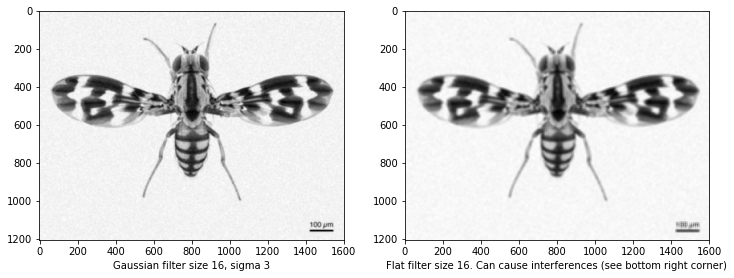

In [195]:
fig = plt.figure(figsize=(12, 12))

smooth2 = cv2.filter2D(noisy, -1, k)
fig.add_subplot(1, 2, 1)
plt.imshow(smooth2, cmap='gray')
plt.xlabel("Gaussian filter size 16, sigma 3")

fig.add_subplot(1, 2, 2)
ugly = cv2.filter2D(noisy, -1, np.ones((16, 16)))
plt.imshow(ugly, cmap='gray')
plt.xlabel("Flat filter size 16. Can cause interferences (see bottom right corner)")


## Edge cases

What should our filter do when it reaches the edges?
  - only calculate if all kernel spots filled
  - fill up with constant
  - wrap around
  - repeat border pixel
  - reflect images

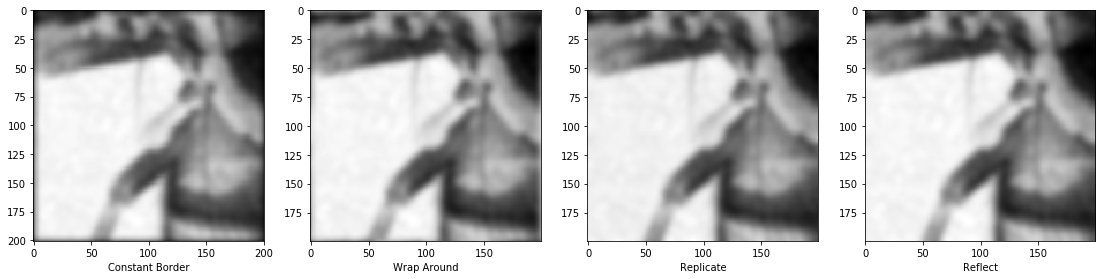

In [203]:
fig = plt.figure(figsize=(24, 12))

noisy2 = noisy[500:700, 600:800]

const = cv2.filter2D(cv2.copyMakeBorder(noisy2, k.shape[0], k.shape[0], k.shape[0], k.shape[0], borderType=cv2.BORDER_CONSTANT, value=0 ), -1, k)
fig.add_subplot(1, 5, 1)
plt.imshow(const[k.shape[0]-1:-k.shape[0], k.shape[0]-1:-k.shape[0]], cmap='gray')
plt.xlabel("Constant Border")

wrap = cv2.filter2D(noisy2, -1, k, borderType=cv2.BORDER_WRAP)
fig.add_subplot(1, 5, 2)
plt.imshow(wrap, cmap='gray')
plt.xlabel("Wrap Around")

repl = cv2.filter2D(noisy2, -1, k, borderType=cv2.BORDER_REPLICATE)
fig.add_subplot(1, 5, 3)
plt.imshow(repl, cmap='gray')
plt.xlabel("Replicate")

refl = cv2.filter2D(noisy2, -1, k, borderType=cv2.BORDER_REFLECT)
fig.add_subplot(1, 5, 4)
plt.imshow(refl, cmap='gray')
plt.xlabel("Reflect")


In [191]:
noisy.shape

(1205, 1600)